In [ ]:
# see if this tokenizer improves with w2v

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
%cd /content/drive/MyDrive/301_project


/content/drive/.shortcut-targets-by-id/1MYdHZqeVKSuQzIzZWrfBqMgi2EgY91a0/301_project


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("imdb.csv", usecols=["review", "sentiment"], encoding='latin-1')
## 1 - positive, 0 - negative
df.sentiment = (df.sentiment == "positive").astype("int")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [4]:

val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)


def train_val_test_split(df=None, train_percent=0.7, test_percent=0.15, val_percent=0.15):
  df = df.sample(frac=1)
  train_df = df[: int(len(df)*train_percent)]
  test_df = df[int(len(df)*train_percent)+1 : int(len(df)*(train_percent+test_percent))]
  val_df = df[int(len(df)*(train_percent + test_percent))+1 : ]
  return train_df, test_df, val_df

train_df, test_df, val_df = train_val_test_split(df, 0.7, 0.15, 0.15)
train_labels, train_texts = train_df.values[:,1], train_df.values[:,0]
val_labels, val_texts = val_df.values[:,1], val_df.values[:,0]
test_labels, test_texts = test_df.values[:,1], test_df.values[:,0]
print(len(train_df), len(test_df), len(val_df))
print(len(train_texts), len(train_labels), len(val_df))

35000 7499 7499
35000 35000 7499


In [5]:
train_texts[0]

'Set in 1976 for no apparent reason other than to keep the set dressers busy, \'The Box\' was directed by Richard Kelly (\'Donnie Darko\'), and stars Cameron Diaz and James Marsden as Norma and Arthur Lewis, a young couple who are supposedly struggling financially even though they both have successful careers--she as a high school teacher, he as an optical specialist at NASA\'s Langley, Virginia, Research Center. They have one child, Walter (Sam Oz Stone).<br /><br />One day the Lewises find a parcel on their doorstep, containing a black box with a big red button. There is a note from a \'Mr. Steward\' indicating that he will return at 5:00 PM to explain about the box.<br /><br />The mysterious Arlington Steward, played by Frank Langella, shows up at the appointed time, nattily attired in an elegant Savile Row suit. He is polite but businesslike, however his most noticeable feature is his face, half of which appears to have been blown off and improperly attended to. Langella is the onl

# cleaning

In [6]:
from string import punctuation
from os import listdir
from nltk.corpus import stopwords
from pickle import dump

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# turn a doc into clean tokens
def clean_doc(data):
  preprocessed_data = []
  for doc in data:
    # split into tokens by white space
    doc=doc.lower()
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)

    preprocessed_data.append(tokens)

  return preprocessed_data

In [9]:
X_train = clean_doc(train_texts)
X_val = clean_doc(val_texts)
X_test=clean_doc(test_texts)


In [10]:
print(len(X_train), len(X_val), len(X_test))

35000 7499 7499


In [11]:
X_train[0]


'set apparent reason keep set dressers busy box directed richard kelly donnie darko stars cameron diaz james marsden norma arthur lewis young couple supposedly struggling financially even though successful careersshe high school teacher optical specialist nasas langley virginia research center one child walter sam oz stonebr br one day lewises find parcel doorstep containing black box big red button note mr steward indicating return pm explain boxbr br mysterious arlington steward played frank langella shows appointed time nattily attired elegant savile row suit polite businesslike however noticeable feature face half appears blown improperly attended langella thing worth watching movie however unfortunately upstaged makeup resembles harvey two face dent aaron eckhart christopher nolans dark knight like elephant room one try ignore little distractingbr br steward explains return hours collect button time decide unlock push button give million cash catchand big oneis somewhere stranger 

In [14]:
len(X_train)

35000

# Tokenize and padding

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [16]:
# fit a tokenizer
def create_tokenizer(lines,NUM_WORDS):
	tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the maximum document length
def max_length(lines):
	return max([len(s.split()) for s in lines])
 
# padding
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

In [17]:
# create tokenizer
NUM_WORDS=20000

tokenizer = create_tokenizer(X_train,NUM_WORDS)

# calculate max document length
length = max_length(X_train)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1

print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# pad data
X_train = encode_text(tokenizer, X_train, length)
X_val = encode_text(tokenizer, X_val, length)
X_test = encode_text(tokenizer, X_test, length)
print(X_train.shape)

Max document length: 1423
Vocabulary size: 142704
(35000, 1423)


# process y

In [18]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

y_train = y_train.astype('int')
y_val = y_val.astype('int')
y_test = y_test.astype('int')

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

In [19]:
word_index=tokenizer.word_index
len(word_index)

142703

# hyperband to find hyperparams

In [ ]:
pip install -U "ray[tune]"==1.11.0


     |████████████████████████████████| 52.7 MB 109 kB/s 
     |████████████████████████████████| 4.1 MB 39.0 MB/s 
     |████████████████████████████████| 241 kB 47.1 MB/s 
     |████████████████████████████████| 125 kB 34.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers

#import ray
from ray import tune
from ray.tune.integration.keras import TuneReportCallback

In [ ]:
def Conv1(config):
  sequence_length = X_train.shape[1]

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(config['num_filters'], (config["conv_filters_1"], EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_1 = Conv2D(config['num_filters'], (config["conv_filters_2"], EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_2 = Conv2D(config['num_filters'], (config["conv_filters_3"], EMBEDDING_DIM),activation=config['act'])(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - config["conv_filters_1"] + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - config["conv_filters_2"] + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - config["conv_filters_3"] + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  #reshape = Reshape((3*config['num_filters'],))(flatten)

  #penultimate layer
  dense_1 = Dense(128, activation=config['act'], kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(config['reg']))(flatten)
  dropout = Dropout(config['dropout'])(flatten)
  
  output = Dense(units=2, activation='softmax')(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model


In [ ]:
def Conv1(config):
  sequence_length = X_train.shape[1]

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(100, (2, EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_1 = Conv2D(100, (3, EMBEDDING_DIM),activation=config['act'])(reshape)
  conv_2 = Conv2D(100, (4, EMBEDDING_DIM),activation=config['act'])(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - 2 + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - 3 + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - 4 + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  #reshape = Reshape((3*config['num_filters'],))(flatten)

  #penultimate layer
  dense_1 = Dense(128, activation=config['act'], kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(config['reg']))(flatten)
  dropout = Dropout(config['dropout'])(flatten)
  
  output = Dense(units=2, activation='softmax')(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model


In [ ]:
def tune_model(config):
  model=Conv1(config)
  model.compile(
          loss="categorical_crossentropy",
          optimizer=tf.keras.optimizers.Adam(
              lr=config["lr"]),
          metrics=["accuracy"])

  model.fit(
      X_train,
      y_train,
      batch_size=round(config['batch_size']),
      epochs=10,
      verbose=1,
      validation_data=(X_val, y_val),
      callbacks=[TuneReportCallback({
          "mean_accuracy": "accuracy"
      })])

## hyperband

In [ ]:
from ray.tune.schedulers import HyperBandScheduler

In [ ]:
hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration', #budget
    metric='mean_accuracy',
    mode='max',
    max_t=10,
    reduction_factor=3) #after each run, discard these many models

In [ ]:
import grpc

In [ ]:
# create the gRPC stub
options = [('grpc.max_message_length', 100 * 1024 * 1024)]
channel = grpc.insecure_channel(server_url, options = options)
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

NameError: ignored

In [ ]:
analysis = tune.run(
        tune_model,
        name="exp",
        resources_per_trial={
            "gpu": 1,
            #"cpu": 4
        },
        config={
          # "num_filters": tune.grid_search([50,100]),
          # "conv_filters_1": tune.grid_search([3,4,5]),
          # "conv_filters_2": tune.grid_search([3,4,5]),
          # "conv_filters_3": tune.grid_search([3,4,5]),
          'dropout':tune.uniform(0, 1),
          'reg':tune.uniform(0.001, 1),
          'batch_size':tune.grid_search([64,128]),
        },
        scheduler=hyperband_scheduler)

_InactiveRpcError: ignored

In [ ]:
best_trial = analysis.get_best_trial("mean_accuracy", "max", "last")
best_accuracy = best_trial.metric_analysis["mean_accuracy"]["last"]
best_trial_config = best_trial.config
print(best_trial_config)
print(best_accuracy)

In [ ]:
def train_mnist(config):
    num_classes = 10
    epochs = 12

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    #define model
    model = keras.Sequential()
    #first
    model.add(layers.Conv2D(filters=round(config["conv_filters"]), kernel_size=(3, 3), activation='tanh', input_shape=(28,28,1)))
    #hidden
    model.add(layers.AveragePooling2D())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='tanh'))

    model.add(layers.AveragePooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(units=120, activation='tanh'))

    model.add(layers.Dense(units=84, activation='tanh'))
    model.add(layers.Dropout(config['dropout']))
    #output
    model.add(layers.Dense(units=num_classes, activation = 'softmax'))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(
            lr=config["lr"]),
        metrics=["accuracy"])

    model.fit(
        x_train,
        y_train,
        batch_size=round(config['batch_size']),
        epochs=epochs,
        verbose=0,
        validation_data=(x_test, y_test),
        callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])

# use word2vec as embedding layer

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors


EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)


In [ ]:


vocabulary_size

20000

In [ ]:
#don't run
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'word {word} not in w2v')
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

word doesnt not in w2v
word didnt not in w2v
word isnt not in w2v
word wasnt not in w2v
word itbr not in w2v
word moviebr not in w2v
word filmbr not in w2v
word humour not in w2v
word timebr not in w2v
word hasnt not in w2v
word shouldnt not in w2v
word favourite not in w2v
word theatre not in w2v
word thembr not in w2v
word lowbudget not in w2v
word hitchcock not in w2v
word thisbr not in w2v
word allbr not in w2v
word onebr not in w2v
word thatbr not in w2v
word himbr not in w2v
word mebr not in w2v
word wellbr not in w2v
word bmovie not in w2v
word storybr not in w2v
word tarzan not in w2v
word aint not in w2v
word keaton not in w2v
word endbr not in w2v
word overthetop not in w2v
word herebr not in w2v
word seagal not in w2v
word writerdirector not in w2v
word onbr not in w2v
word waybr not in w2v
word isbr not in w2v
word outbr not in w2v
word againbr not in w2v
word goodbr not in w2v
word welles not in w2v
word lifebr not in w2v
word wwii not in w2v
word sinatra not in w2v
word c

In [ ]:
#dump to pkl
with open('new_clean_w2v_train.pkl', 'wb') as handle:
    pkl.dump(embedding_matrix, handle)

In [ ]:
# load if saevd
with open('new_clean_w2v_train.pkl', 'rb') as handle:
    embedding_matrix=pkl.load(handle)

In [ ]:
from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)  #-------unsure

In [ ]:
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.36816406e-02,  1.07910156e-01, -1.35742188e-01, ...,
        -2.13867188e-01, -8.25195312e-02, -1.68457031e-02],
       [ 1.74804688e-01, -1.09863281e-01, -2.00195312e-01, ...,
         7.95898438e-02,  2.80761719e-02, -2.02636719e-02],
       ...,
       [ 2.64658650e-01, -6.75371561e-02, -7.58862974e-01, ...,
        -9.86703001e-02,  4.44904613e-02, -5.53499180e-02],
       [-9.22851562e-02,  2.74658203e-04, -1.60156250e-01, ...,
        -1.68457031e-02, -3.14453125e-01,  1.26953125e-01],
       [ 3.01513672e-02, -4.74609375e-01, -6.64062500e-02, ...,
        -3.57421875e-01,  1.73828125e-01,  1.33666992e-02]])

In [ ]:
embedding_matrix.shape

(20000, 300)

#normal  embedding layer

In [20]:
from keras.layers import Embedding
EMBEDDING_DIM=100
vocabulary_size=min(len(word_index)+1,NUM_WORDS)

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM)

# define model

In [ ]:
from math import *

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Reshape,Conv2D, MaxPooling2D, Flatten, Input, concatenate, Add, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from keras import regularizers

# train

In [21]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import regularizers

In [22]:
def Conv1():
  sequence_length = X_train.shape[1]
  filter_sizes = [3,4,5]
  num_filters = 100
  drop = 0.5
  num_classes=2

  inputs = Input(shape=(sequence_length,))
  embedding = embedding_layer(inputs)
  reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

  conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
  conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
  conv_2 = Conv2D(num_filters, (filter_sizes[2], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

  maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
  maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
  maxpool_2 = MaxPooling2D((sequence_length - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)

  merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
  flatten = Flatten()(merged_tensor)
  reshape = Reshape((3*num_filters,))(flatten)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

  # this creates a model that includes
  model = Model(inputs, output)

  return model

model=Conv1()

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1423)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1423, 100)    2000000     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1423, 100, 1  0           ['embedding[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 1421, 1, 100  30100       ['reshape[0][0]']            

# run model

In [24]:
from datetime import datetime
import tensorflow as tf

In [25]:
# Custom Class to print specified parameters during training
class PrintingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        # print(logs.keys())
        print(
            "The average loss for epoch {} is {:7.2f} "
            "and accuracy is {:7.2f}.".format(
                epoch, logs["val_loss"], logs["val_accuracy"]
            ))
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print("LR is:", lr)
    

# defining a function to checkpoint the model 

checkpoint_filepath = './new_cleaning_normal_embed/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = True)




optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train,
          batch_size=256,
          validation_data=(X_val, y_val),
          epochs=2)
print(history.history.keys())

In [26]:
from tensorflow.keras.optimizers import Adam

In [27]:
adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history = model.fit(X_train, y_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.7397The average loss for epoch 0 is    0.52 and accuracy is    0.81.
LR is: 0.001

Epoch 1: val_accuracy improved from -inf to 0.80651, saving model to ./new_cleaning_normal_embed/checkpoint
137/137 [==============================] - 66s 389ms/step - loss: 0.6191 - accuracy: 0.7397 - val_loss: 0.5176 - val_accuracy: 0.8065
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.8354The average loss for epoch 1 is    0.47 and accuracy is    0.85.
LR is: 0.001

Epoch 2: val_accuracy improved from 0.80651 to 0.84571, saving model to ./new_cleaning_normal_embed/checkpoint
137/137 [==============================] - 34s 250ms/step - loss: 0.4856 - accuracy: 0.8354 - val_loss: 0.4745 - val_accuracy: 0.8457
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.4243 - accuracy: 0.8778The average loss for epoch 2 is    0.46 and accuracy is    0.86.
LR is: 0.001

Ep

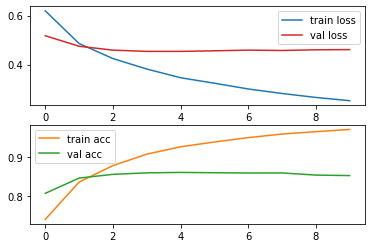

In [28]:
import matplotlib.pyplot as plt
num_epoch=10
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

In [29]:
model.load_weights(checkpoint_filepath)

adam = Adam(lr=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
#callbacks = [EarlyStopping(monitor='val_loss')]

start = datetime.now()

history2 = model.fit(X_train, y_train, batch_size=256, epochs=5, verbose=1, validation_data=(X_val, y_val),
         callbacks=[PrintingCallback(), model_checkpoint_callback])  # starts training

end = datetime.now()

print('time: ',end-start)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


137/137 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.9381The average loss for epoch 0 is    0.45 and accuracy is    0.86.
LR is: 0.001

Epoch 1: val_accuracy improved from 0.86025 to 0.86158, saving model to ./new_cleaning_normal_embed/checkpoint
137/137 [==============================] - 35s 252ms/step - loss: 0.3230 - accuracy: 0.9381 - val_loss: 0.4496 - val_accuracy: 0.8616
Epoch 2/5
137/137 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.9484The average loss for epoch 1 is    0.45 and accuracy is    0.86.
LR is: 0.001

Epoch 2: val_accuracy did not improve from 0.86158
137/137 [==============================] - 34s 251ms/step - loss: 0.3016 - accuracy: 0.9484 - val_loss: 0.4503 - val_accuracy: 0.8609
Epoch 3/5
137/137 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.9552The average loss for epoch 2 is    0.45 and accuracy is    0.86.
LR is: 0.001

Epoch 3: val_accuracy did not improve from 0.86158
137/137 [=

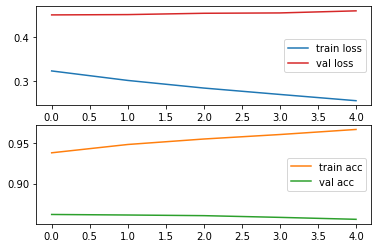

In [31]:
import matplotlib.pyplot as plt
num_epoch=5
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(num_epoch), history2.history['loss'], 'tab:blue', label="train loss")
ax1.plot(range(num_epoch), history2.history['val_loss'], 'tab:red', label="val loss")

ax2.plot(range(num_epoch), history2.history['accuracy'], 'tab:orange', label="train acc")
ax2.plot(range(num_epoch), history2.history['val_accuracy'], 'tab:green', label="val acc")

ax1.legend()
ax2.legend()

# test

In [32]:
start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.4581468403339386
Test accuracy: 0.854513943195343
time:  0:00:02.701872


In [33]:
model.load_weights(checkpoint_filepath)

start = datetime.now()
score, acc = model.evaluate(X_test, y_test, verbose=0)
end = datetime.now()
print('Test loss:', score)
print('Test accuracy:', acc)
print('time: ',end-start)

Test loss: 0.4496515095233917
Test accuracy: 0.8575810194015503
time:  0:00:02.586017
